In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/third_take

/content/drive/MyDrive/Colab Notebooks/third_take


In [4]:
#===========================================================
# Config
#===========================================================

import yaml

with open('./src/config.yaml') as file:
    config = yaml.safe_load(file.read())

assert config['task'] == 'regression'

df_path_dict = {'train': config['input_dir_root']+'train.csv',
                'test': config['input_dir_root']+'test.csv',
                'sample_submission': config['input_dir_root']+'sample_submission.csv',
                'folds': config['input_dir']+'folds.csv',}

config['feat_excluded'] = [
    config['id'], config['target'],
    'art_series_id',
    'title',
    'description',
    'long_title',
    'more_title',
    'acquisition_date',
    'dating_presenting_date',
    'sub_title'
    ]

In [5]:
config['model']

'lgbm'

In [6]:

#===========================================================
# Metrics
#===========================================================

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
    
def get_score(y_true, y_pred):
    score = rmsle(y_true, y_pred)
    return score

def custom_eval(preds, data):
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = np.mean(y_true == y_pred)
    return 'accuracy', metric, True

#===========================================================
# Model params
#===========================================================

def get_params(n_fold, config):
    if config['model'] == "lgbm":
        # parameters document
        # https://lightgbm.readthedocs.io/en/latest/Parameters.html
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': 0.05,
            'max_depth': -1,
            'subsample': 0.6,
            'colsample_bytree': 0.4,
            'num_leaves': 32,
            'min_data_in_leaf': 20,
            #'reg_alpha': 0.1,
            #'reg_lambda': 0.1,
            'seed': int(2 ** n_fold)+config['seed'],
            'num_boost_round': 10000,
            'early_stopping_rounds': 200,
            'verbose_eval': 100
            }
    elif config['model'] == "xgb":
        # parameters document
        # https://xgboost.readthedocs.io/en/latest/parameter.html
        params = {
            'objective':'reg:squarederror',
            'eval_metric':'rmse',
            'learning_rate': 0.05,
            'max_depth': 10,
            'subsample': 0.6,
            'colsample_bytree': 0.4,  
            #'min_child_weight':3,
            #'gamma':0.25,
            'seed': int(2 ** n_fold)+config['seed'],
            'num_boost_round': 5000,
            'early_stopping_rounds': 50,
            'verbose_eval': 10
            }
    elif config['model'] == "catb":
        # parameters document
        # https://catboost.ai/docs/concepts/loss-functions.html
        # https://catboost.ai/docs/concepts/python-reference_parameters-list.html
        params = {
            "loss_function": "RMSE",
            "eval_metric": "RMSE",
            "task_type": "CPU",
            'learning_rate': 0.05,
            "iterations": 6000,
            "early_stopping_rounds": 200,
            "verbose": 100,
            "random_seed": int(2 ** n_fold)+config['seed']
            }
    else:
        raise(ValueError("model name is not defined"))
    
    return params


In [7]:
# !pip install catboost
# from catboost import CatBoostClassifier, CatBoostRegressor

In [8]:
#===========================================================
# Library
#===========================================================
import gc
import json
import os
import random
import sys
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

warnings.filterwarnings('ignore')

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import xgboost as xgb
# from catboost import CatBoostClassifier, CatBoostRegressor
from gensim.models.word2vec import Word2Vec
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (GroupKFold, GroupShuffleSplit, KFold,
                                     StratifiedKFold)
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm



In [9]:
#===========================================================
# Utils
#===========================================================

def seed_everything(seed=1996):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


@contextmanager
def timer(name):
    t0 = time.time()
    logger.info(f'[{name}] start')
    yield
    logger.info(f'[{name}] done in {time.time() - t0:.0f} s')
    logger.info('')


def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger(config['output_dir']+config['fname_log_cv'])

def load_df(path, df_name, config):
    if path.split('.')[-1]=='csv':
        if config['debug']:
            df = pd.read_csv(path, nrows=1000)
        else:
            df = pd.read_csv(path)
    elif path.split('.')[-1]=='pkl':
        df = pd.read_pickle(path)
    logger.info(f"{df_name} shape / {df.shape} ")
    return df

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        logger.info('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def drop_null_columns(train_df, test_df, columns, th=0.99, verbose=False):
    logger.info("original columns: {}".format(len(columns)))
    df = train_df.append(test_df, sort=False)
    drop_col = []
    use_col = []
    for col in columns:
        null_num = df[col].isnull().sum()
        try:
            unique_num = df[col].value_counts()[0]
        except:
            unique_num = 0
        null_rate = (null_num + unique_num) / len(df)
        if null_rate >= th:
            drop_col.append(col)
            if verbose:
                print(col, null_rate)
        else:
            use_col.append(col)
    
    logger.info("{} columns is null.".format(len(drop_col)))
    return use_col


In [10]:
#===========================================================
# Visualize
#===========================================================
def get_importance(feature_importance_df_, top_n=50):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:top_n].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)][["feature", "importance"]].reset_index(drop=True)
    best_features = best_features.sort_values(by="importance", ascending=False)

    return best_features, list(cols)

def display_importances(feature_importance_df_, img_fname):
    best_features, _ = get_importance(feature_importance_df_)

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(img_fname)



In [11]:
#===========================================================
# Model
#===========================================================
def modeling_lightgbm(train_x, train_y, valid_x, valid_y, test_x, config):

    params = config['params']

    # set data structure
    lgb_train = lgb.Dataset(train_x,
                            label=train_y,
                            free_raw_data=False)
    lgb_test = lgb.Dataset(valid_x,
                            label=valid_y,
                            free_raw_data=False)

    model = lgb.train(
                params,
                lgb_train,
                valid_sets=[lgb_train, lgb_test],
                valid_names=['train', 'test'],
                num_boost_round=params['num_boost_round'],
                early_stopping_rounds= params['early_stopping_rounds'],
                verbose_eval=params['verbose_eval'],
                feval=config['feval'],
                )

    valid_pred = model.predict(valid_x, num_iteration=model.best_iteration)
    sub_pred = model.predict(test_x, num_iteration=model.best_iteration)
    
    return valid_pred, sub_pred, model.feature_importance(importance_type='gain', iteration=model.best_iteration)

def modeling_xgboost(train_x, train_y, valid_x, valid_y, test_x, config):

    params = config['params']

    xgb_train = xgb.DMatrix(train_x, train_y)
    xgb_test = xgb.DMatrix(valid_x, valid_y)
    
    model = xgb.train(
        params, 
        xgb_train,
        evals=[(xgb_train, 'train'), (xgb_test, 'val')],
        num_boost_round=params['num_boost_round'],
        early_stopping_rounds=params['early_stopping_rounds'],
        verbose_eval=params['verbose_eval'])
    
    valid_pred = model.predict(xgb.DMatrix(valid_x), ntree_limit=model.best_ntree_limit)
    sub_pred = model.predict(xgb.DMatrix(test_x), ntree_limit=model.best_ntree_limit)

    return valid_pred, sub_pred

def modeling_catboost(train_x, train_y, valid_x, valid_y, test_x, config):
    
    params = config['params']

    model = CatBoostRegressor(**params)
    
    model.fit(
        train_x,
        train_y,
        eval_set=(valid_x, valid_y),
        use_best_model=True,
        early_stopping_rounds=params["early_stopping_rounds"],
        verbose=params["verbose"])
    
    valid_pred = model.predict(valid_x)
    sub_pred = model.predict(test_x)
    
    return valid_pred, sub_pred, model.get_feature_importance()
    
def get_model_predict(train_x, train_y, valid_x, valid_y, test_x,  config):

    if config['model'] == "lgbm":
        return modeling_lightgbm(train_x, train_y, valid_x, valid_y, test_x, config)
    
    elif config['model'] == "xgb":
        return modeling_xgboost(train_x, train_y, valid_x, valid_y, test_x, config)

    elif config['model'] == "catb":
        return modeling_catboost(train_x, train_y, valid_x, valid_y, test_x, config)
    
    else:
        raise(ValueError("model name is not defined"))



In [12]:
#===========================================================
# Train and Predict
#===========================================================

def kfold_modeling(train_df, test_df, config):
    # Create arrays and dataframes to store results
    seed_everything(config['seed'])
    folds = load_df(path=df_path_dict['folds'], df_name='folds', config=config)

    oof_preds = np.zeros((train_df.shape[0]))
    sub_preds = np.zeros((test_df.shape[0]))

    if config['model'] in ["lgbm", 'catb']:
        feature_importance_df = pd.DataFrame()

    # k-fold
    scores = []
    for n_fold in range(config['num_folds']):

        logger.info('Starting fold {}'.format(n_fold)) 

        train_idx, valid_idx = folds[folds['folds'] != n_fold].index,  folds[folds['folds'] == n_fold].index
        train_fold = pd.read_pickle(config['input_dir']+f'train_fold{n_fold}.pkl')
        valid_fold = pd.read_pickle(config['input_dir']+f'valid_fold{n_fold}.pkl')
        test_fold = pd.read_pickle(config['input_dir']+f'test_fold{n_fold}.pkl')

        feats = [f for f in test_fold.columns if f not in config['feat_excluded']]
        #feats = drop_null_columns(train_df, test_df, feats)

        config['feats'] = feats
    
        train_x, train_y = train_fold[config['feats']], train_fold[config['target']]
        valid_x, valid_y = valid_fold[config['feats']], valid_fold[config['target']]
        test_x = test_fold[config['feats']]
        
        config['params'] = get_params(n_fold, config)

        if config['custom_eval']:
            config['feval'] = custom_eval
            config['params']['metric'] = "custom"
        logger.info('params: {}'.format(config['params']))
        
        if config['do_log_scale']:
            train_y = np.log1p(train_y)
            valid_y = np.log1p(valid_y)
        
        if n_fold == 0:
            logger.info(config['feats'])
        logger.info('len(trn_idx) : {} len(val_idx) : {} len(feature) : {}'.format(len(train_idx), len(valid_idx), len(config['feats'])))

        if config['model'] in ["lgbm", 'catb']:
            valid_pred, sub_pred, feature_importance = get_model_predict(train_x, train_y, valid_x, valid_y, test_x, config)
        else:
            valid_pred, sub_pred = get_model_predict(train_x, train_y, valid_x, valid_y, test_x, config)
        
        if config['do_log_scale']:
            valid_pred = np.exp(valid_pred) - 1
            sub_pred = np.exp(sub_pred) - 1
            valid_y = np.exp(valid_y) - 1
        
        if config['cat_negative_value']:
            valid_pred = np.where(valid_pred < 0, 0.0, valid_pred)
            sub_pred = np.where(sub_pred < 0, 0.0, sub_pred)

        oof_preds[valid_idx] = valid_pred
        sub_preds += (sub_pred / config['num_folds'])

        if config['model'] in ["lgbm", 'catb']:
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = test_x.columns
            fold_importance_df["importance"] = np.log1p(feature_importance)
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        logger.info("{} fold {} score: {:<8.5f}".format(config['model'], n_fold, get_score(valid_y, oof_preds[valid_idx])))
        scores.append(get_score(valid_y, valid_pred))
        logger.info('')

        del train_x, train_y, valid_x, valid_y
        gc.collect()
    
    logger.info("{} CV(all) score: {:<8.5f}".format(config['model'], get_score(train_df[config['target']], oof_preds)))
    logger.info("{} CV(ave) score: {:<8.5f}±{:<8.5f}".format(config['model'], np.mean(scores), np.std(scores)))

    if config['model'] in ["lgbm", 'catb']:
        # display importances
        display_importances(feature_importance_df, config['output_dir']+config['fname_importance'])
        feature_importance_df.to_csv(config['output_dir']+'feature_importance.csv', index=False)

    return oof_preds, sub_preds


Basic Config
   debug: False
   task: regression
   input_dir_root: ./input/
   input_dir_root_jn: ../input/
   input_dir: ./src/input/
   input_dir_jn: ../src/input/
   output_dir: ./src/output/
   output_dir_jn: ../src/output/
   output_dir_fold: ../src/input/
   output_dir_pp: ../src/input/
   output_dir_cv: ./src/output/
   fname_submission: submission.csv
   fname_log_fold: log_fold
   fname_log_pp: log_pp
   fname_log_cv: log_cv
   fname_importance: feature_importance.png
   fname_cm: cm.png
   cm_class: ['0', '1']
   id: object_id
   target: likes
   seed: 1996
   num_folds: 5
   split_type: group
   split_group: art_series_id
   split_target: likes
   shuffle: False
   model: lgbm
   num_class: 1
   num_seed: 1
   do_log_scale: True
   cat_negative_value: True
   do_weight: False
   custom_eval: None
   feval: None
   optim_th: False
   feat_excluded: ['object_id', 'likes', 'art_series_id', 'title', 'description', 'long_title', 'more_title', 'acquisition_date', 'dating_presenti

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.782319	test's rmse: 0.994486
[200]	train's rmse: 0.607618	test's rmse: 0.974468
[300]	train's rmse: 0.497665	test's rmse: 0.970002
[400]	train's rmse: 0.415855	test's rmse: 0.967358
[500]	train's rmse: 0.351617	test's rmse: 0.965294
[600]	train's rmse: 0.299818	test's rmse: 0.963995
[700]	train's rmse: 0.258913	test's rmse: 0.96301
[800]	train's rmse: 0.224455	test's rmse: 0.962688
[900]	train's rmse: 0.194518	test's rmse: 0.962911
Early stopping, best iteration is:
[775]	train's rmse: 0.232538	test's rmse: 0.962489


lgbm fold 0 score: 0.96238 

Starting fold 1
params: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': -1, 'subsample': 0.6, 'colsample_bytree': 0.4, 'num_leaves': 32, 'min_data_in_leaf': 20, 'seed': 1998, 'num_boost_round': 10000, 'early_stopping_rounds': 200, 'verbose_eval': 100}
len(trn_idx) : 9621 len(val_idx) : 2405 len(feature) : 1480


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.776977	test's rmse: 1.02533
[200]	train's rmse: 0.603076	test's rmse: 1.00406
[300]	train's rmse: 0.494531	test's rmse: 0.995454
[400]	train's rmse: 0.414306	test's rmse: 0.993461
[500]	train's rmse: 0.350388	test's rmse: 0.992497
[600]	train's rmse: 0.299994	test's rmse: 0.992231
[700]	train's rmse: 0.258483	test's rmse: 0.991262
[800]	train's rmse: 0.223873	test's rmse: 0.991211
[900]	train's rmse: 0.195883	test's rmse: 0.991067
[1000]	train's rmse: 0.171714	test's rmse: 0.990874
[1100]	train's rmse: 0.15112	test's rmse: 0.990869
[1200]	train's rmse: 0.133388	test's rmse: 0.990694
Early stopping, best iteration is:
[1031]	train's rmse: 0.165131	test's rmse: 0.990598


lgbm fold 1 score: 0.99032 

Starting fold 2
params: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': -1, 'subsample': 0.6, 'colsample_bytree': 0.4, 'num_leaves': 32, 'min_data_in_leaf': 20, 'seed': 2000, 'num_boost_round': 10000, 'early_stopping_rounds': 200, 'verbose_eval': 100}
len(trn_idx) : 9621 len(val_idx) : 2405 len(feature) : 1480


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.774756	test's rmse: 1.03533
[200]	train's rmse: 0.600944	test's rmse: 1.01941
[300]	train's rmse: 0.490287	test's rmse: 1.01596
[400]	train's rmse: 0.409751	test's rmse: 1.01566
[500]	train's rmse: 0.346468	test's rmse: 1.01515
[600]	train's rmse: 0.29576	test's rmse: 1.01487
[700]	train's rmse: 0.255259	test's rmse: 1.01369
[800]	train's rmse: 0.221948	test's rmse: 1.01346
[900]	train's rmse: 0.193217	test's rmse: 1.01281
[1000]	train's rmse: 0.169371	test's rmse: 1.01232
[1100]	train's rmse: 0.148799	test's rmse: 1.01217
[1200]	train's rmse: 0.131032	test's rmse: 1.01195
[1300]	train's rmse: 0.115966	test's rmse: 1.01141
[1400]	train's rmse: 0.103103	test's rmse: 1.01135
[1500]	train's rmse: 0.0913215	test's rmse: 1.01128
[1600]	train's rmse: 0.0808553	test's rmse: 1.01146
Early stopping, best iteration is:
[1455]	train's rmse: 0.0964553	test's rmse: 1.01125


lgbm fold 2 score: 1.01085 

Starting fold 3
params: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': -1, 'subsample': 0.6, 'colsample_bytree': 0.4, 'num_leaves': 32, 'min_data_in_leaf': 20, 'seed': 2004, 'num_boost_round': 10000, 'early_stopping_rounds': 200, 'verbose_eval': 100}
len(trn_idx) : 9621 len(val_idx) : 2405 len(feature) : 1480


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.779539	test's rmse: 1.01985
[200]	train's rmse: 0.605528	test's rmse: 1.0057
[300]	train's rmse: 0.496662	test's rmse: 1.00141
[400]	train's rmse: 0.416047	test's rmse: 0.999042
[500]	train's rmse: 0.351211	test's rmse: 0.997682
[600]	train's rmse: 0.300934	test's rmse: 0.997052
[700]	train's rmse: 0.259207	test's rmse: 0.996704
[800]	train's rmse: 0.225047	test's rmse: 0.997044
[900]	train's rmse: 0.195587	test's rmse: 0.995577
[1000]	train's rmse: 0.171239	test's rmse: 0.994405
[1100]	train's rmse: 0.1508	test's rmse: 0.994476
[1200]	train's rmse: 0.133554	test's rmse: 0.99467
Early stopping, best iteration is:
[1042]	train's rmse: 0.162525	test's rmse: 0.994197


lgbm fold 3 score: 0.99402 

Starting fold 4
params: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': -1, 'subsample': 0.6, 'colsample_bytree': 0.4, 'num_leaves': 32, 'min_data_in_leaf': 20, 'seed': 2012, 'num_boost_round': 10000, 'early_stopping_rounds': 200, 'verbose_eval': 100}
len(trn_idx) : 9621 len(val_idx) : 2405 len(feature) : 1480


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.767329	test's rmse: 1.07432
[200]	train's rmse: 0.595208	test's rmse: 1.05371
[300]	train's rmse: 0.488313	test's rmse: 1.04557
[400]	train's rmse: 0.408727	test's rmse: 1.04372
[500]	train's rmse: 0.345457	test's rmse: 1.04265
[600]	train's rmse: 0.295288	test's rmse: 1.04098
[700]	train's rmse: 0.254836	test's rmse: 1.04079
[800]	train's rmse: 0.2207	test's rmse: 1.04033
[900]	train's rmse: 0.192941	test's rmse: 1.0395
[1000]	train's rmse: 0.169889	test's rmse: 1.03964
[1100]	train's rmse: 0.149345	test's rmse: 1.03967
Early stopping, best iteration is:
[962]	train's rmse: 0.178075	test's rmse: 1.0393


lgbm fold 4 score: 1.03922 

lgbm CV(all) score: 0.99968 
lgbm CV(ave) score: 0.99936 ±0.02529 
[Run Models] done in 839 s

[submission] start
[submission] done in 1 s



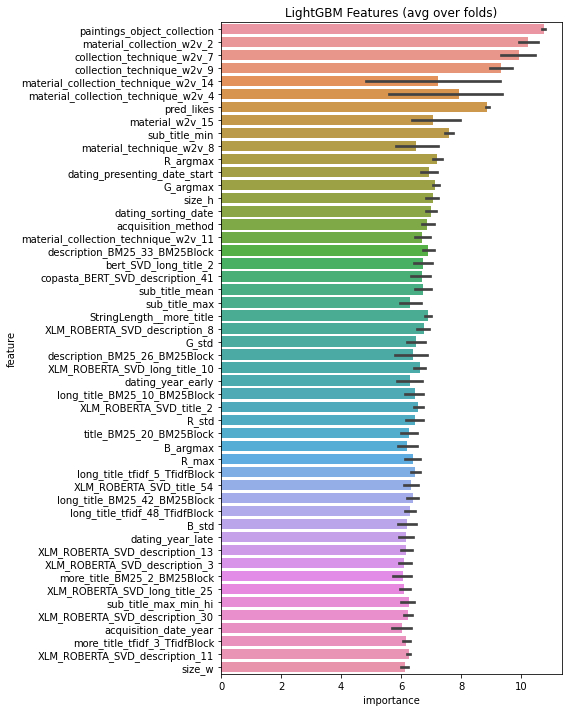

In [13]:
#===========================================================
# Main
#===========================================================
def main():
    logger.info('Basic Config')
    for k, v in config.items():
        logger.info('   {}: {}'.format(k, v))
    logger.info('')

    with timer('Data Loading'):
        train = load_df(path=df_path_dict['train'], df_name='train', config=config)
        #train = reduce_mem_usage(train)
        test = load_df(path=df_path_dict['test'], df_name='test', config=config)
        #test = reduce_mem_usage(test)
        sample_submission = load_df(path=df_path_dict['sample_submission'], df_name='sample_submission', config=config)
    

    with timer('Run Models'):
        if config['num_seed'] > 1:
            oof_preds = []
            sub_preds = []
            for idx in range(config['num_seed']):
                config['seed'] += idx
                oof_pred, sub_pred = kfold_modeling(train, test, config)
                oof_preds.append(oof_pred,)
                sub_preds.append(sub_pred)
            
            oof_pred = np.mean(oof_preds, axis=0)
            sub_pred = np.mean(sub_preds, axis=0)

            logger.info("{} CV(RSA) score: {:<8.5f}".format(config['model'], get_score(train[config['target']], sub_pred)))
        else:
            oof_pred, sub_pred = kfold_modeling(train, test, config)

        train['pred'] = oof_pred
        test['pred'] = sub_pred
        train[[config['id'], 'pred']].to_pickle(config['output_dir']+'oof.pkl')
        test[[config['id'], 'pred']].to_pickle(config['output_dir']+'sub.pkl')
    
    with timer("submission"):
        # submission
        sample_submission[config['target']] = sub_pred
        sample_submission.to_csv(config['output_dir']+config['fname_submission'], index=False)

if __name__ == "__main__":
    main()
